In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta

In [47]:
from hlsstack.hls_funcs.smooth import despike_ts, double_savgol
from scipy.signal import savgol_filter

In [134]:
def full_smooth_ndvi(ts, dates, adjust_min=True):
    from scipy.signal import savgol_filter
    if adjust_min:
        ndvi_min = ts[(dates.dt.month < 3) | (dates.dt.month > 10)].quantile(0.05)
        ts[((dates.dt.month < 3) | (dates.dt.month > 10)) & 
        ((ts > ndvi_min*2.0) | (ts < ndvi_min*0.5))] = np.nan
    ts_ds = pd.Series(
        despike_ts(ts.values, dat_thresh=0.025, days_thresh=61)).interpolate(limit=None, limit_direction='both')
    ts_smooth = pd.Series(savgol_filter(ts_ds, 151, 3), index=ts.index)
    return ts_smooth

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[N:] - cumsum[:-N]) / float(N)

# explore creating SOS
def calc_sos(ndvi_ts):
    ndvi_thresh1 = np.nanpercentile(ndvi_ts[91:201], 40.0)
    date_thresh1 = next(x for x in np.where(ndvi_ts > ndvi_thresh1)[0] if x > 30)
    dndvi_ts = np.ones_like(ndvi_ts) * np.nan
    dndvi_ts[25:] = running_mean(np.diff(ndvi_ts), 25)
    dndvi_thresh2 = np.nanpercentile(dndvi_ts[:date_thresh1], 35.0)
    sos = np.where(dndvi_ts[:date_thresh1] < dndvi_thresh2)[0][-1]
    return sos

def weighted_ndvi(ndvi_smooth1, ndvi_smooth2, sos):
    weights1 = np.ones_like(ndvi_smooth1)
    peak = np.argmax(ndvi_smooth1[150:300]) + 150
    weights1[:sos] = 0
    weights1[sos:peak] = np.linspace(0, 1, peak-sos)**2
    weights1[peak:] = np.linspace(1, 0, len(ndvi_smooth1) - peak)**2
    weights2 = 1.0 - weights1
    ndvi_wtd = np.average(np.array([ndvi_smooth1, ndvi_smooth2]), axis=0, weights=np.array([weights1, weights2]))
    return pd.Series(ndvi_wtd, index=ndvi_smooth1.index)

In [135]:
df = pd.read_csv('./data/extractions/cper_scan_ndvi_2000_2023.csv')

In [136]:
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year

In [137]:
df['Source'] = df['Date'].transform(lambda x: 'LMF' if x.year <= 2015 else 'HLS')

In [138]:
df = df.sort_values(['Id', 'Date'])

<Axes: xlabel='Date', ylabel='NDVI'>

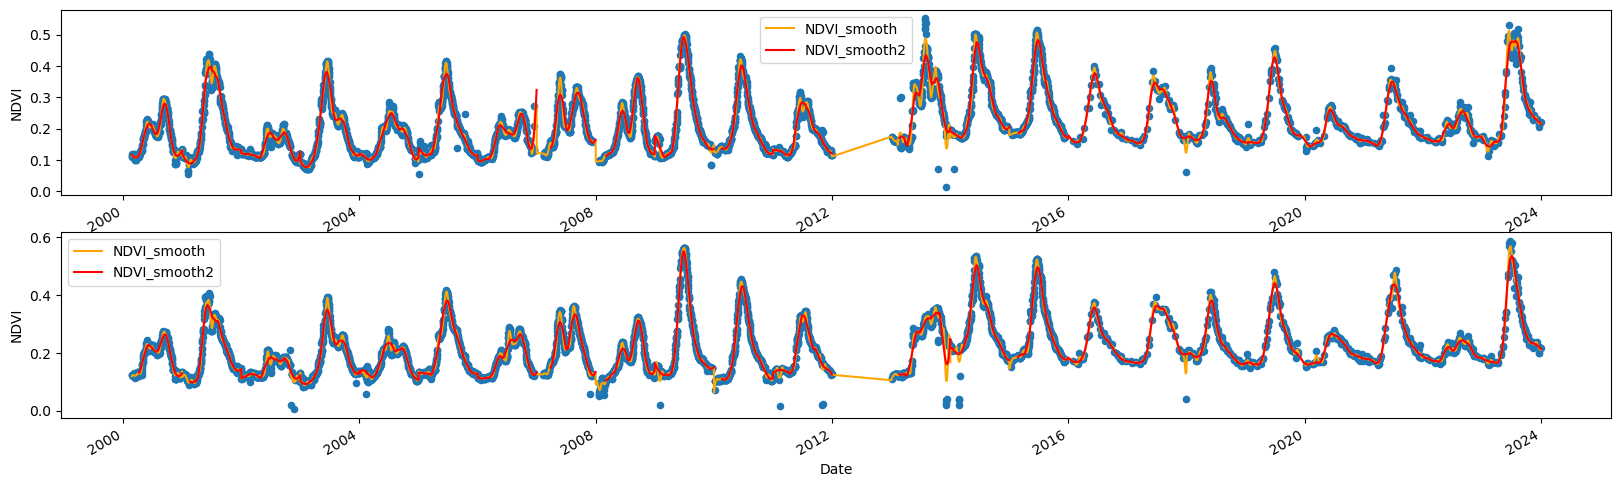

In [139]:
# plot original smooth from adaptive smoothing
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(20, 6))

df[df['Id'] == 'scn.loam'].plot.scatter(x='Date', y='NDVI', ax=ax1)
df[df['Id'] == 'scn.loam'].plot(x='Date', y='NDVI_smooth', c='orange', ax=ax1)
df[df['Id'] == 'scn.loam'].plot(x='Date', y='NDVI_smooth2', c='red', ax=ax1)

df[df['Id'] == 'scn.sand'].plot.scatter(x='Date', y='NDVI', ax=ax2)
df[df['Id'] == 'scn.sand'].plot(x='Date', y='NDVI_smooth', c='orange', ax=ax2)
df[df['Id'] == 'scn.sand'].plot(x='Date', y='NDVI_smooth2', c='red', ax=ax2)

In [140]:
df['NDVI_smooth3'] = df.apply(lambda x: x['NDVI_smooth'] if x['Source'] == 'LMF' else x['NDVI_smooth2'], axis=1)
df['NDVI_smooth_full'] = df.groupby('Id').apply(lambda x: full_smooth_ndvi(x['NDVI'], x['Date'])).reset_index(level=0, drop=True)

In [141]:
# calculate start of season as DOY for each plot and year
df_sos = df.groupby([df['Date'].dt.year, 
                              'Id'])['NDVI_smooth3'].apply(
    lambda x: calc_sos(x)).reset_index().rename(columns={'NDVI_smooth3': 'SOS_doy',
                                                         'Date': 'Year'})
# get as date
df_sos['SOS_date'] = df_sos.apply(lambda x: datetime(x['Year'], 1, 1) + timedelta(days=x['SOS_doy']), axis=1)

# merge with NDVI for plotting
df_sos = pd.merge(df_sos, df[['Date', 'Id', 'NDVI_smooth3']], 
         left_on=['SOS_date', 'Id'],
         right_on=['Date', 'Id'], how='left')

In [177]:
df_gs = df[(df['Date'].dt.dayofyear >= 150) & (df['Date'].dt.dayofyear <= 300)]
ndvi_peak_vals = df_gs.groupby(['Id', 'Year']).apply(lambda x: x['NDVI_smooth'].iloc[np.argmax(x['NDVI_smooth'])])
ndvi_peak_dates = df_gs.groupby(['Id', 'Year']).apply(lambda x: x['Date'].iloc[np.argmax(x['NDVI_smooth'])])

In [178]:
# get average from two smooths, weighted by distance to SOS and peak NDVI 
ndvi_smooth_avg = df.groupby(['Year', 'Id']).apply(lambda x: weighted_ndvi(x['NDVI_smooth'], 
                                                                  x['NDVI_smooth_full'],
                                                                  df_sos[(df_sos['Year'] == x.name[0]) & 
                                                                         (df_sos['Id'] == x.name[1])]['SOS_doy'].values[0]))
df['NDVI_smooth_avg'] = ndvi_smooth_avg.droplevel(list(np.arange(ndvi_smooth_avg.index.nlevels-1)))

In [179]:
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='green', lw=2, label='NDVI'),
                   Line2D([0], [0], marker='o', color='w', label='Peak NDVI',
                          markerfacecolor='red', markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='Start of season',
                          markerfacecolor='blue', markersize=8),]

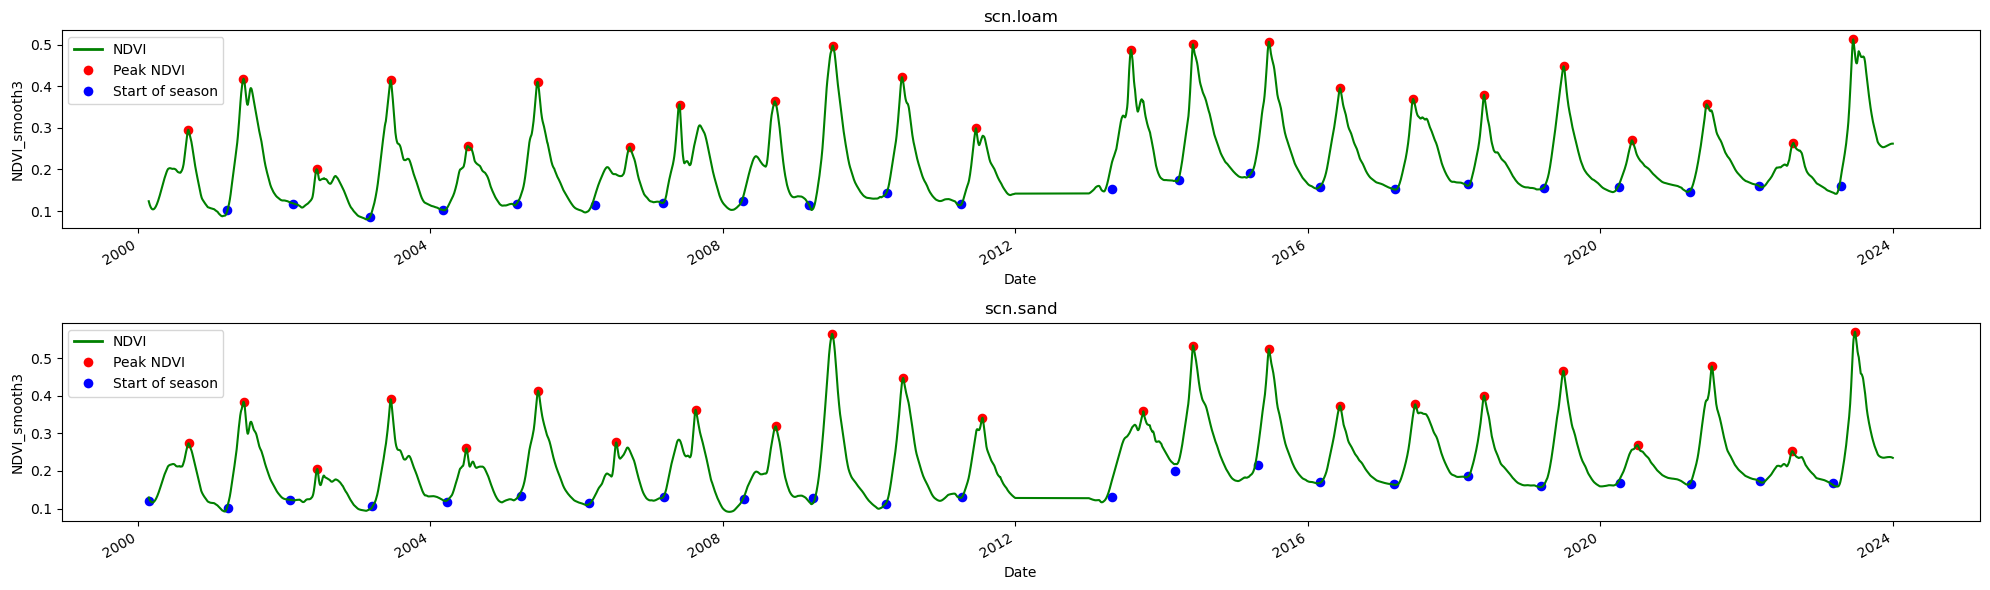

In [180]:
# plot updated smooth with start of season (blue) and peak of season (red)
fig, axs = plt.subplots(nrows=2, figsize=(20, 6))
for idx, plot in enumerate(df['Id'].unique()):
    #df[df['Id'] == plot].plot.scatter(x='Date', y='NDVI', ax=axs[idx], c='grey', s=5)
    #df[df['Id'] == plot].plot(x='Date', y='NDVI_smooth', c='orange', ax=axs[idx])
    #df[df['Id'] == plot].plot(x='Date', y='NDVI_smooth3', c='green', ax=axs[idx])
    axs[idx].scatter(ndvi_peak_dates.loc[plot].values, ndvi_peak_vals.loc[plot].values, c='red', s=35)
    df_sos[df_sos['Id'] == plot].plot.scatter(x='SOS_date', y='NDVI_smooth3',  ax=axs[idx], c='blue', s=35)
    df[df['Id'] == plot].plot(x='Date', y='NDVI_smooth_avg', ax=axs[idx], c='green')
    #df[df['Id'] == plot].plot(x='Date', y='NDVI_smooth_full', ax=axs[idx], c='black')
    axs[idx].set_title(plot)
    axs[idx].legend(handles=legend_elements, loc='upper left')
plt.tight_layout()
plt.savefig('./outputs/cper_ndvi_ts_fig.png', dpi=100)

In [154]:
df_ndvi_out = df[[ 'Id', 'Date', 'Year', 'NDVI_smooth_avg', 'Source']]
df_ndvi_out = df_ndvi_out[df_ndvi_out['Date'].dt.year != 2012]

In [157]:
df_ndvi_out.to_csv('./outputs/cper_scan_ndvi_ts.csv', index=False)
df_sos.sort_values(['Id', 'Year']).to_csv('./outputs/cper_scan_sos.csv', index=False)